### Imports

In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.gridspec as gridspec

### Data

The data I gathered here is based on the JSON files Spotify can provide in 30 days by a request. So basically, it is my own listening history. Additionally, I had to get the audio features of every song using the Spotify API, and the song genres I was able to get were scraped by me from albumoftheyear.org.

I am not providing the code for that because the process was long and kinda ugly. The data actually also includes precise information about devices being used to play the music, and I would have to provide my private API key.

But here is a list of steps to take to end up with the same data as me:
* Request your data from Spotify
* Import the data from multiple JSON files
* Delete data without a Spotify song URL (so for example, podcasts)
* Add data with the same URL by milliseconds played
* Do the same with songs that have the same name and artist  
  (Sometimes there are different editions/releases/remasters etc. of the same song, or the same song is on different albums)
* Divide milliseconds played by duration to get the amount of replays (loose definition of a replay)
* Use the Spotify API to get audio features for every distinct URL
* Scrape the genres from albumoftheyear.org  
  (What you have to do is get the genre of the album where the song is from or even the artist for maximum possible data)

***

Fun Fact: At first, I wanted to classify the songs by the time played but there weren't ANY patterns in the data.

In [2]:
with open("data.json") as f:
        dataJSON = json.load(f)

### Basic keywords and definitnions

In [3]:
class atr:
    MS_PLAYED = 'ms_played'
    TRACK_NAME = 'master_metadata_track_name'
    ARTIST_NAME = 'master_metadata_album_artist_name'
    ALBUM_NAME = 'master_metadata_album_album_name'
    SPOTIFY_TRACK_URI = 'spotify_track_uri'
    DANCEABILITY = 'danceability'
    ENERGY = 'energy'
    KEY = 'key'
    LOUDNESS = 'loudness'
    MODE = 'mode'
    SPEECHINESS = 'speechiness'
    ACOUSTICNESS = 'acousticness'
    INSTRUMENTALNESS = 'instrumentalness'
    LIVENESS = 'liveness'
    VALENCE = 'valence'
    TEMPO = 'tempo'
    DURATION_MS = 'duration_ms'
    TIME_SIGNATURE = 'time_signature'
    REPLAYS = 'replays'
    CATEGORY = 'category'
    GENRE = 'genre'

category = atr.CATEGORY
features = [atr.DANCEABILITY, atr.ACOUSTICNESS, atr.ENERGY, atr.INSTRUMENTALNESS, atr.LIVENESS, atr.LOUDNESS, atr.SPEECHINESS, atr.TEMPO, atr.DURATION_MS]
featuresC = [atr.MODE ,atr.TIME_SIGNATURE]

### Preparing the data for analysis

In [4]:
data: pd.DataFrame = pd.DataFrame(dataJSON)

# Delete data without genres
data = data.loc[data[atr.GENRE].str.len() != 0]

# Delete data with incredibly low attributes ()
for attr in [atr.DANCEABILITY, atr.ENERGY, atr.SPEECHINESS, atr.ACOUSTICNESS, atr.INSTRUMENTALNESS, atr.LIVENESS, atr.VALENCE, atr.TEMPO]:
    data = data[data[attr] != 0]

# Delete data I haven't listened to fully at least 2 times
data = data[data[atr.REPLAYS] > 1]

# Delete unimportant columns
data = data.drop(columns=[atr.MS_PLAYED, atr.TRACK_NAME, atr.ARTIST_NAME, atr.ALBUM_NAME, atr.SPOTIFY_TRACK_URI, atr.REPLAYS, atr.CATEGORY, atr.KEY])

# Make categorical features actually categorical 
for stat in featuresC:
        data.loc[:, stat] = data[stat].astype('category')

data

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.330,0.611,-9.571,1,0.0495,0.002190,0.76900,0.1070,0.2410,172.606,817832.0,1,"[Progressive Metal, Alternative Metal, Progres..."
1,0.323,0.804,-7.397,1,0.0369,0.000073,0.83500,0.0957,0.3840,144.756,943529.0,5,"[Progressive Metal, Alternative Metal, Progres..."
2,0.160,0.572,-6.949,1,0.0321,0.003670,0.74500,0.0952,0.0932,96.926,3816373.0,4,"[Stoner Metal, Doom Metal]"
3,0.459,0.567,-9.133,0,0.0571,0.009890,0.78600,0.1090,0.3890,87.477,764457.0,1,"[Progressive Metal, Alternative Metal, Progres..."
4,0.415,0.530,-9.338,0,0.0314,0.002090,0.75000,0.1100,0.0586,114.174,713192.0,1,"[Progressive Metal, Alternative Metal, Progres..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2821,0.562,0.855,-10.634,1,0.0677,0.006309,0.58000,0.2095,0.6370,146.239,40986.0,4,[Cinematic Classical]
2822,0.563,0.905,-5.224,1,0.0889,0.006570,0.00187,0.3250,0.3670,150.011,17600.0,4,"[Cinematic Classical, Synth Funk, Christmas]"
2823,0.326,0.265,-10.517,1,0.0347,0.476000,0.89600,0.1490,0.0383,117.076,29107.0,1,"[Darksynth, Synthwave, Electro House, Cinemati..."
2824,0.631,0.612,-12.475,1,0.2240,0.014013,0.57700,0.4070,0.3505,147.154,24320.0,5,"[Sequencer & Tracker, Cinematic Classical]"


### Features histograms

In [5]:
def is_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

We will use this [function](https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting) to remove outliers and make the histograms more readable

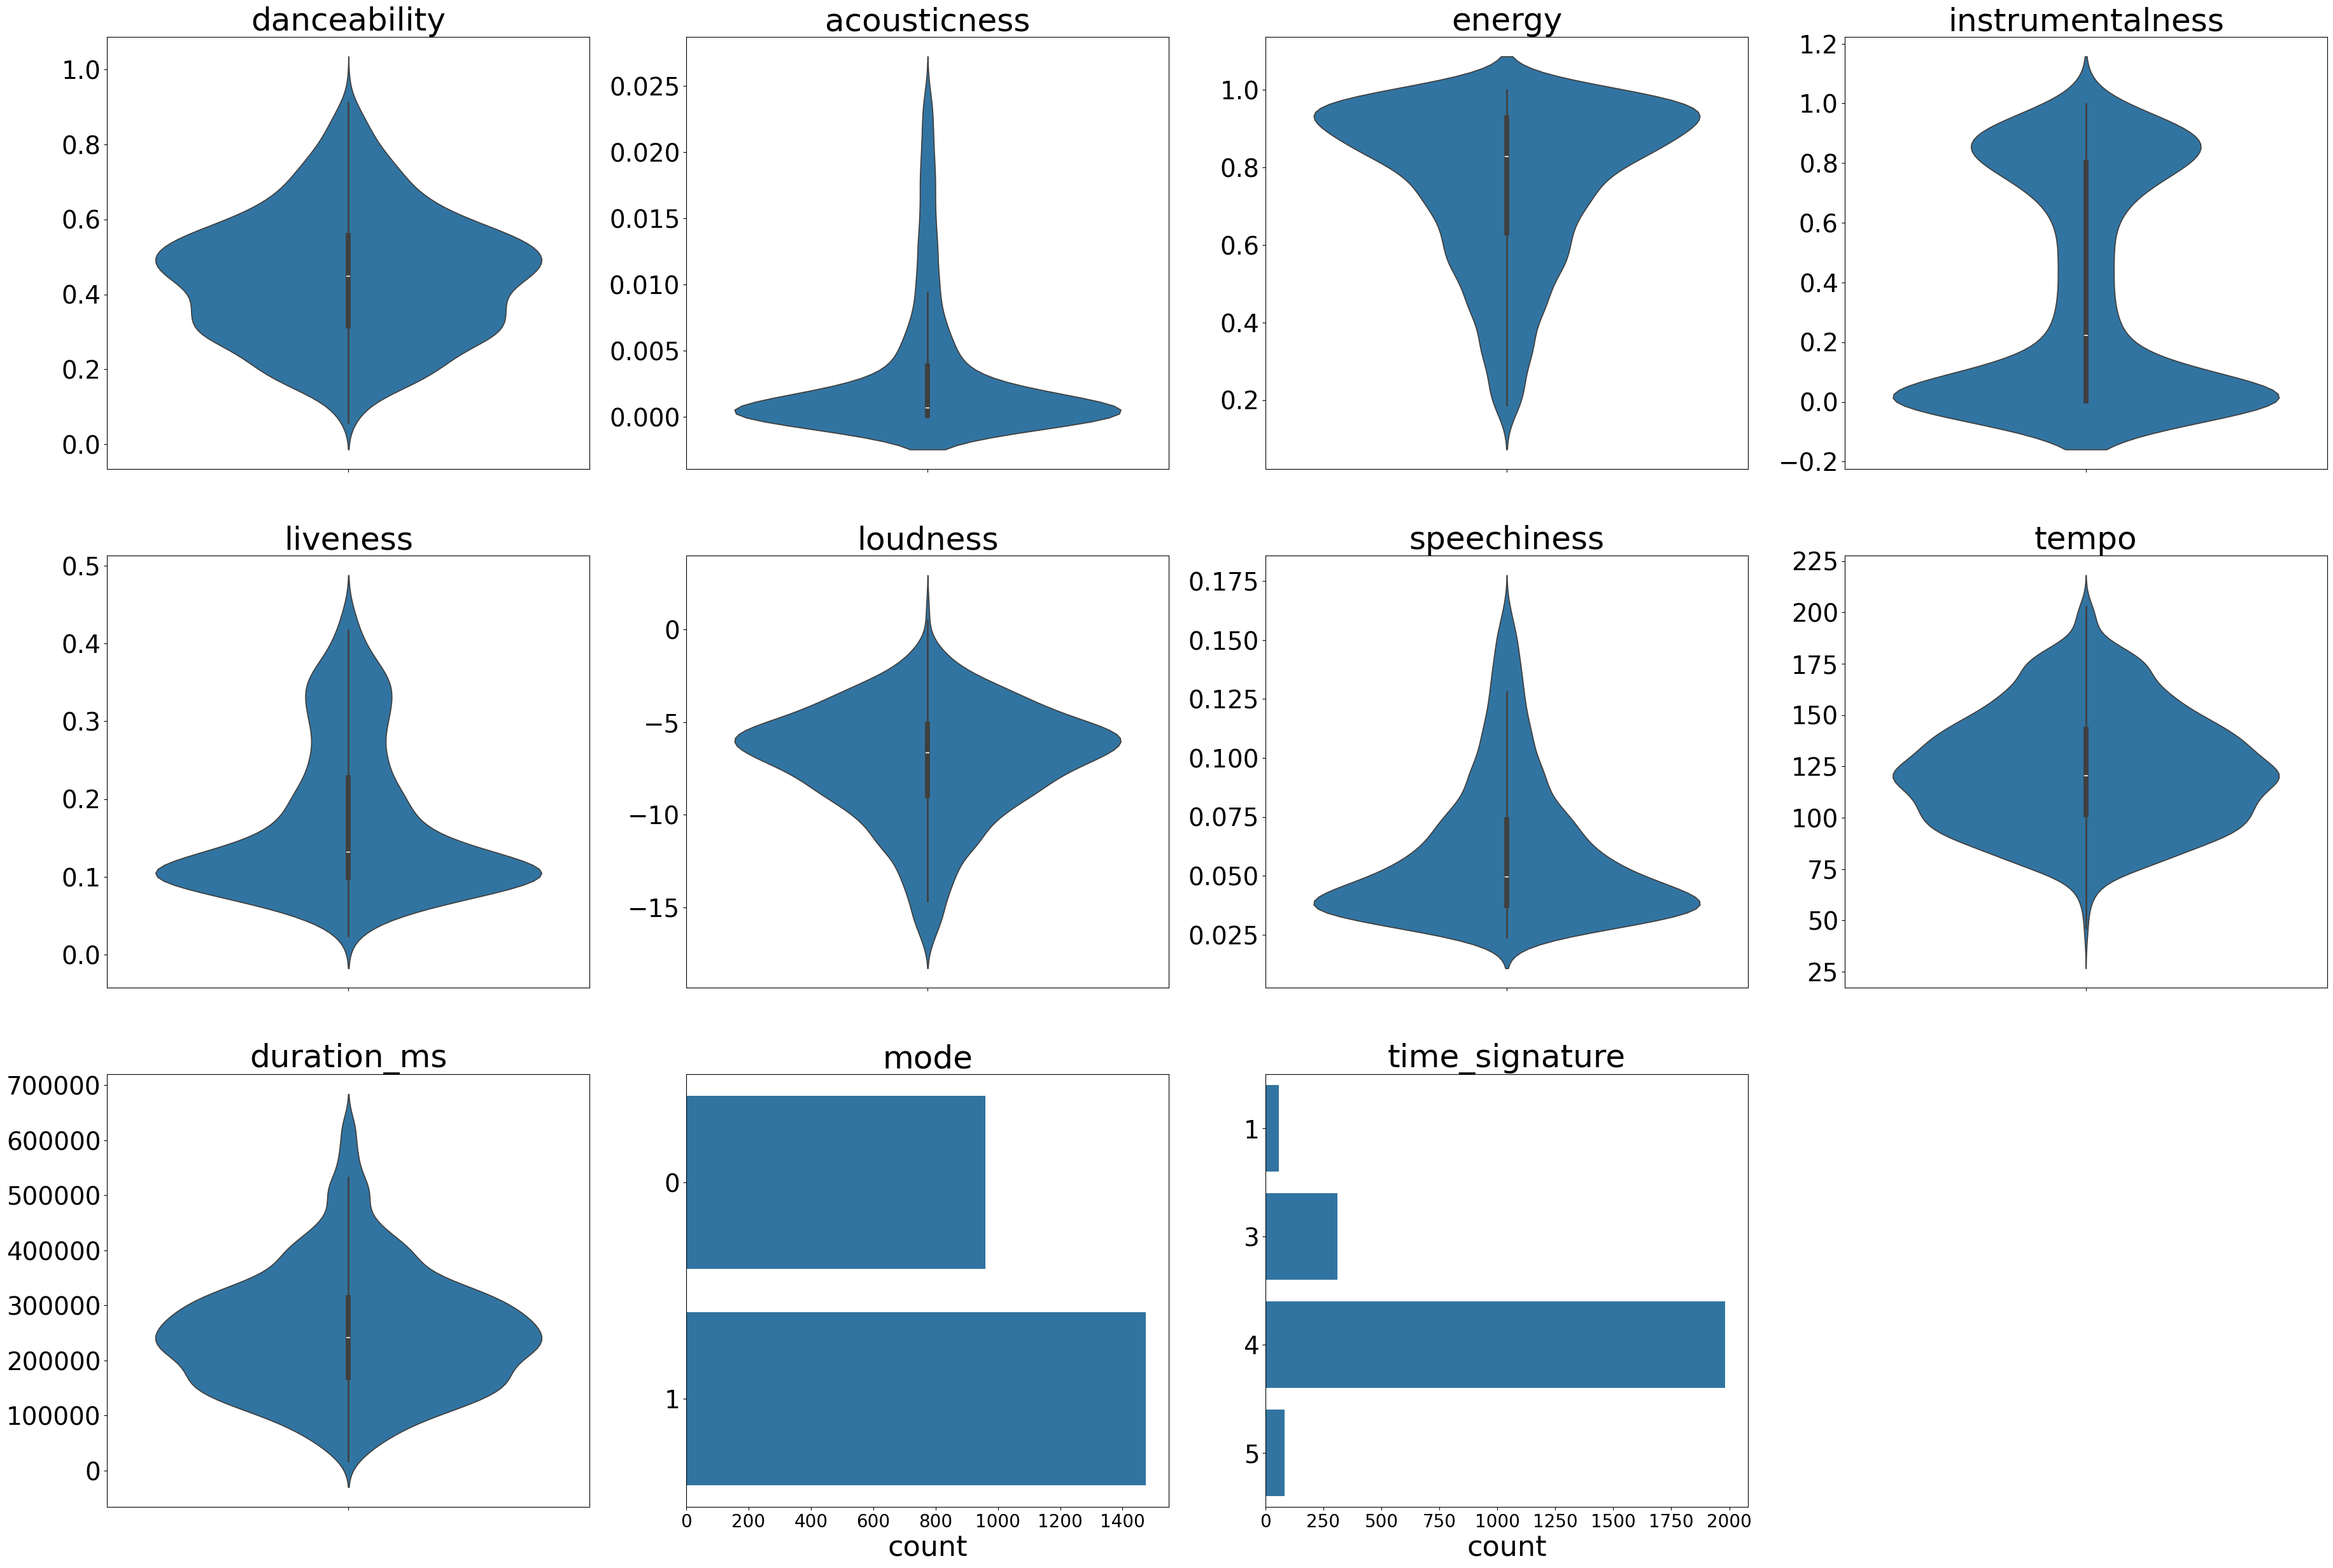

In [6]:
plt.figure(figsize=(45, 30))

for i, feature in enumerate(features):
    plt.subplot(3, 4, i+1)
    sns.violinplot(data=data[~is_outlier(data[feature].values)], y=feature)
    plt.title(feature, fontsize=36)
    plt.ylabel('', fontsize=32)
    plt.yticks(size = 28)

for i, feature in enumerate(featuresC, start=len(features)):
    plt.subplot(3, 4, i+1)
    sns.countplot(data=data, y=feature)
    plt.title(feature, fontsize=36)
    plt.xlabel('count', fontsize=32)
    plt.ylabel('', fontsize=32)
    plt.xticks(size = 20)
    plt.yticks(size = 28)

# plt.tight_layout()
plt.show()

Now that the data is composed of important things only, we need to find a way to properly categorize it

In [7]:
distinct_genres = set([genre for genres in data[atr.GENRE] for genre in genres])
print(distinct_genres)
print(len(distinct_genres))

{'Garage Punk', 'Melodic Metalcore', 'Post-Rock', 'Noisecore', 'Stoner Metal', 'Atmospheric Black Metal', 'Post-Hardcore', 'Breakcore', 'Alt-Pop', 'Progressive Pop', 'Chiptune', 'Electronic Dance Music', 'Post-Black Metal', 'Horrorcore', 'Noise Rock', 'Glitch Hop', 'Ambient Techno', 'Alternative Metal', 'Brutal Prog', 'No Wave', 'Blues Rock', 'Shoegaze', 'Gothic Rock', 'Space Ambient', 'Cloud Rap', 'Sludge Metal', 'Illbient', 'Instrumental Hip Hop', 'Alternative Rock', 'Uptempo Hardcore', 'Cinematic Classical', 'New Rave', 'Art Pop', 'Downtempo', 'Coldwave', 'Progressive Metal', 'Chamber Music', 'Synth Funk', 'Field Recordings', 'Tech House', 'Wonky', 'Footwork', 'Digital Hardcore', 'Melodic Death Metal', 'Progressive Metalcore', 'Doomgaze', 'Funk Rock', 'Abstract Hip Hop', 'Experimental Rock', 'Christmas', 'Indie Pop', 'Math Rock', 'IDM', 'Sound Collage', 'Industrial Metal', 'Psychedelic Pop', 'Rock Opera', 'Musical Parody', 'Deconstructed Club', 'Industrial', 'Pop Soul', 'Stoner Rock

As we can see the current amount of genres is far too big for a simple categorization problem

The first idea that comes to mind is to only use the first genre from the list

In [8]:
distinct_leading_genres = set([genres[0] for genres in data[atr.GENRE]])
print(distinct_leading_genres)
print(len(distinct_leading_genres))

{'Post-Rock', 'Stoner Metal', 'Breakcore', 'Chiptune', 'Electronic Dance Music', 'Post-Black Metal', 'Noise Rock', 'Glitch Hop', 'Alternative Metal', 'Cloud Rap', 'Shoegaze', 'Sludge Metal', 'Alternative Rock', 'Uptempo Hardcore', 'Cinematic Classical', 'Art Pop', 'Downtempo', 'Progressive Metal', 'Tech House', 'Synth Funk', 'Chamber Music', 'Funk Rock', 'Experimental Rock', 'Math Rock', 'IDM', 'Industrial Metal', 'Musical Parody', 'Stoner Rock', 'Hardcore [EDM]', 'Heavy Metal', 'Symphonic Metal', 'Memphis Rap', 'Jazz-Funk', 'Trap Metal', 'Synthpop', 'Industrial Hip Hop', 'Death Metal', 'Power Metal', 'Brostep', 'Trap', 'Avant-Garde Metal', 'Nu Metal', 'Jazz Fusion', 'Techno', 'Teen Pop', 'Sequencer & Tracker', 'Garage Rock', 'Folk Rock', 'Funk Metal', 'Plunderphonics', 'Comedy Rap', 'Psychedelic Rock', 'Grunge', 'Thrash Metal', 'Psychedelic Soul', 'Dance-Pop', 'Post-Metal', 'Trance', 'Psybient', 'Synthwave', 'Progressive Rock', 'Black Metal', 'Hard Rock', 'Jazz', 'Folk', 'Experimental

Unfortunately it didn't reduce the problem as much as expected.
It would also be nice if we didn't just throw away every genre from the list except the first one as it could give us some valuable information for a better classification.

So instead we need to analyze the problem further

## Unsupervised classification
The data isn't exactly classified so let's use some techniques from unsupervised machine learning to hopefully guide us to something that would help us properly classify the songs. Hopefully it could be at least half-supervised :)

### Feature scaling for analysis

In [9]:
X = data.drop(columns=[atr.GENRE])

sc = StandardScaler()
X[features] = sc.fit_transform(X[features])

X

,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,-0.694371,-0.605235,-0.421292,1,-0.446469,-0.456936,1.023680,-0.641918,0.2410,1.716320,3.130479,1
1,-0.735531,0.252737,0.076486,1,-0.574577,-0.466369,1.198022,-0.709491,0.3840,0.742167,3.845931,5
2,-1.693961,-0.778607,0.179064,1,-0.623381,-0.450339,0.960284,-0.712481,0.0932,-0.930857,20.197799,4
3,0.064141,-0.800835,-0.321004,0,-0.369197,-0.422615,1.068586,-0.629958,0.3890,-1.261369,2.826675,1
4,-0.194577,-0.965316,-0.367943,0,-0.630498,-0.457381,0.973491,-0.623978,0.0586,-0.327547,2.534881,1
...,...,...,...,...,...,...,...,...,...,...,...,...
2821,0.669774,0.479455,-0.664686,1,-0.261423,-0.438577,0.524430,-0.028969,0.6370,0.794040,-1.291231,4
2822,0.675654,0.701727,0.574035,1,-0.045875,-0.437413,-1.002720,0.661719,0.3670,0.925979,-1.424341,4
2823,-0.717891,-2.143360,-0.637897,1,-0.596945,1.654913,1.359155,-0.390758,0.0383,-0.226039,-1.358845,1
2824,1.075490,-0.600790,-1.086218,1,1.327735,-0.404239,0.516506,1.152077,0.3505,0.826046,-1.386092,5


### Elbow method based on K-means clustering

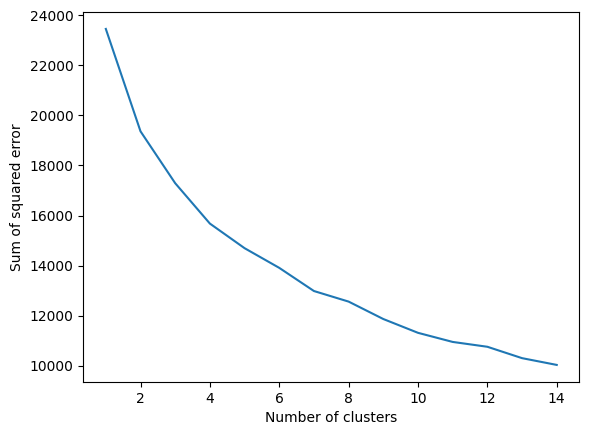

In [10]:
sse = {} # sum of squared error
for k in range(1,15):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X)
    sse[k] = kmeans.inertia_

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of squared error")
plt.show()

There isn't a clear elbow point on the graph, indicating that when it comes to music, the more categories, the better.

A point that is the closest to an elbow point is 7, so let's just run with it

### Cluster analysis (by genres)
After grouping the data into 7 clusters we are going to check what genres are they composed of. For that we need to check the highest occurance rates of genres in every cluster.

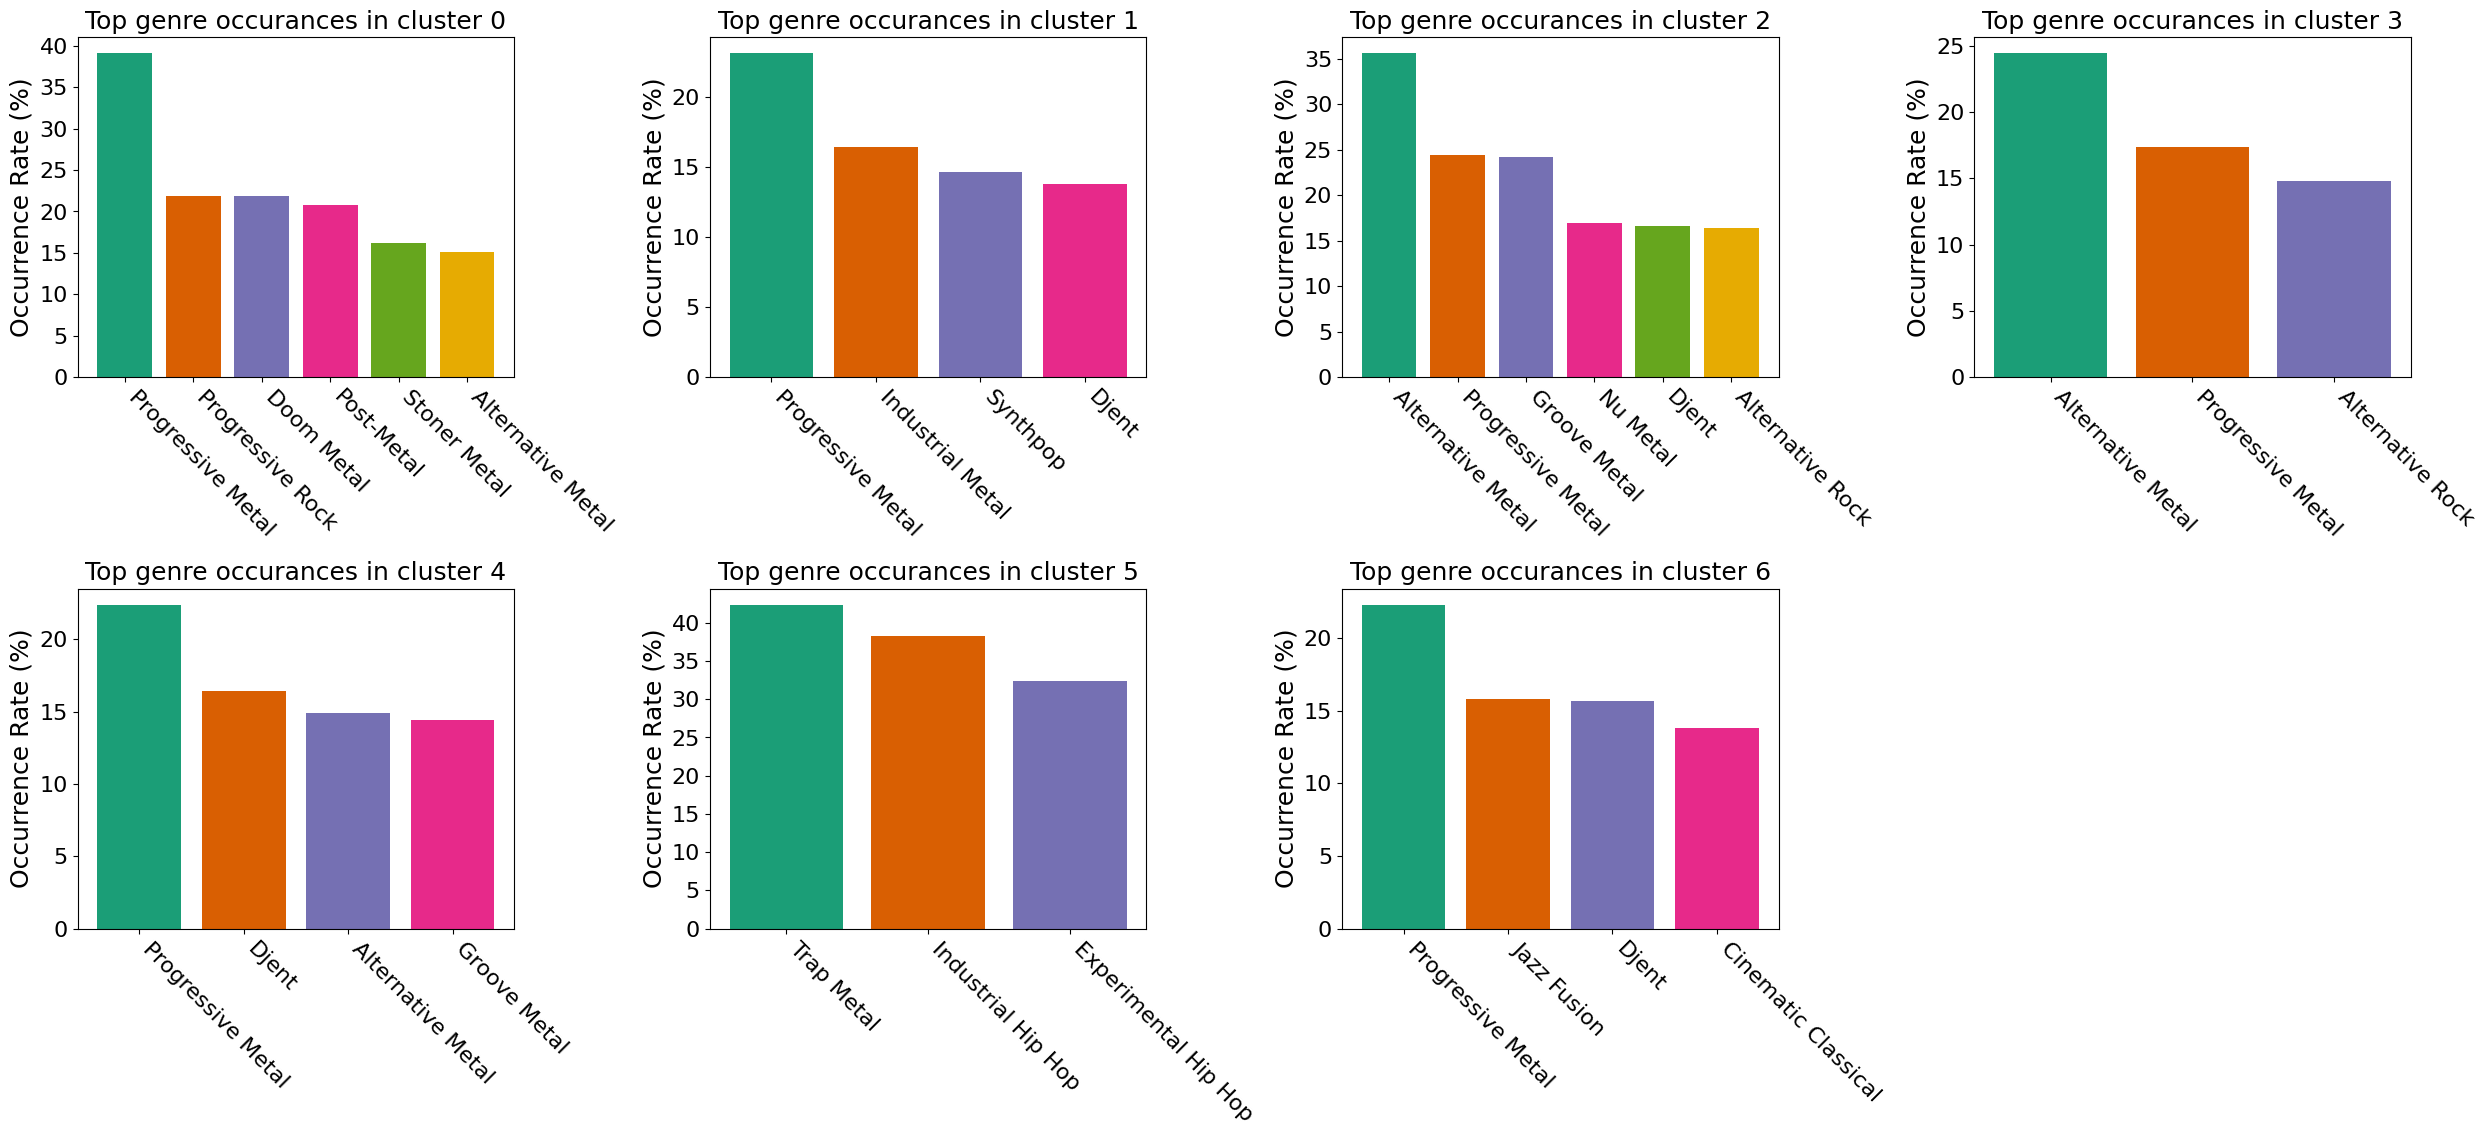

In [11]:
CLUSTER_COUNT = 7
kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=42).fit(X)
data["cluster"] = kmeans.labels_

plt.figure(figsize=(25, 15))

for i in range(CLUSTER_COUNT):
    cluster_data = data.loc[data['cluster'] == i].drop(columns=['cluster'])

    all_genres = [genre for sublist in cluster_data['genre'] for genre in sublist]
    counted_genres = dict(Counter(all_genres))
    occurance_rates = {genre: counted_genres[genre] / len(cluster_data) for genre in counted_genres}
    occurance_rates = {k: v for k, v in sorted(occurance_rates.items(), key=lambda x: -x[1])}
    filtered_genres = {genre: rate*100 for genre, rate in occurance_rates.items() if rate > 0.13}

    plt.subplot(3, 4, i + 1)
    plt.bar(filtered_genres.keys(), filtered_genres.values(), color=plt.get_cmap('Dark2').colors)
    plt.ylabel('Occurrence Rate (%)', fontsize=18)
    plt.title(f'Top genre occurances in cluster {i}', fontsize=18)
    plt.xticks(rotation=-45, fontsize=16, ha='left')
    plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

data = data.drop(columns=['cluster'])

As we can see this gives us a great in-sight to our data. 

The most prominent thing is that almost every cluster is dominated by Progressive Metal as it always shows up in around a 20% rate.
We can draw a conlusion that my listening history mainly focused around Progressive Metal, from my personal experience I can also say that the genre has an ungodly amount of variety in terms of music. When we add these two facts together it isn't a suprise at all why it appears in most clusters

Now that that's out of the way let's further analyse this data for some clues about the grouping of genres:
* Cluster 5 doesn't have Progressive Metal and is purely about Trap and Hip Hop
* Cluster 0 has a great deal of Stoner, Doom and Post-Metal -- all very slow and/or atmospheric subgenres of metal
* Cluster 1 has a suprising amount of Synthpop along with Industrial and Djent -- electronic-sounding subgenres of metal
* Clusters 2 and 3 have more of an Alternative bias, along with some Nu Metal, which can also be considered Alt
* Cluster 6 has Jazz, Djent and Cinematic Classical -- more complex compositions, "high brow" music




### Cluster visualisation using t-SNE
Because it's only possible to make an at most 3-dimensional graph we need to use some "dimension-reducing" algorithms for proper visualisations. I think the most popular and simple one is PCA, but personally i prefer t-SNE as it's actively trying to put similiar data closer and different data further.

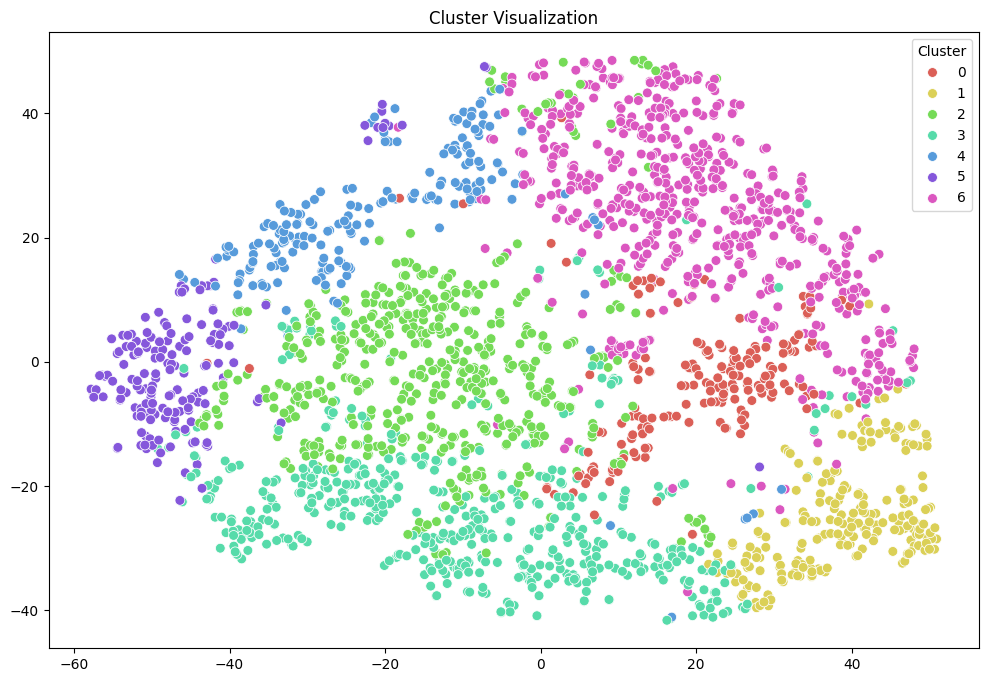

In [12]:
Y_projeciton = kmeans.labels_

X_projection = TSNE(n_components=2).fit_transform(X)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_projection[:, 0], y=X_projection[:, 1], hue=Y_projeciton, palette=sns.color_palette("hls", CLUSTER_COUNT), s=50)
plt.title('Cluster Visualization')
plt.legend(title='Cluster')
plt.show()

## Categorizing the data
We are going to use the guidelines from our previous analysis to categorize the data.

What we will do for every song is search it's list of genres for some keywords and reduce the list to a single genre family

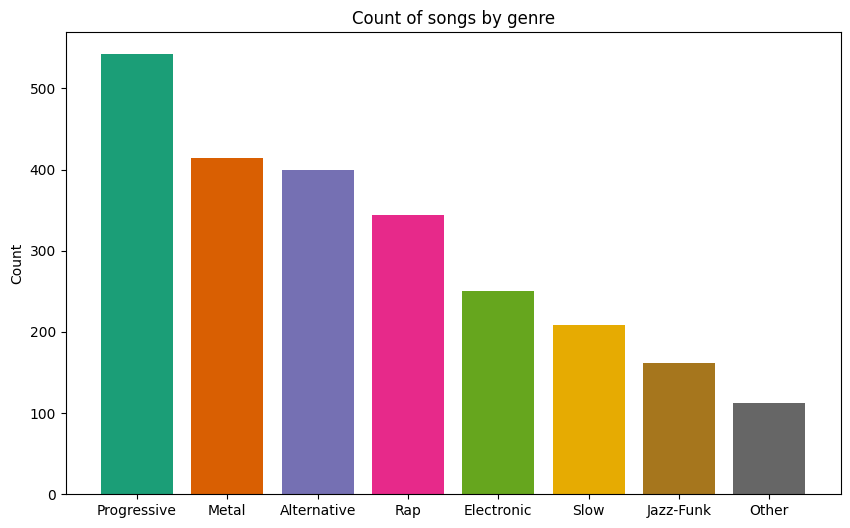

In [13]:
def set_genres_method1():
    '''Checks for every keyword from a single collection in every genre from a list then goes to other keyword collections'''
    is_keyword_in_genres = (
        lambda keywords: (
            lambda arr:
                any(keyword in genre for genre in arr 
                     for keyword in keywords)
        )
    )

    funk_genre_filter = is_keyword_in_genres(["Funk", "Jazz", "Pop", "funk", "jazz"])
    slow_genre_filter = is_keyword_in_genres(["Doom", "Stoner", "Drone", "Post", "Atmospheric", "Ambient", "Noise", "post"])
    rap_genre_filter = is_keyword_in_genres(["Trap", "Rap", "Hop", "Footwork"])
    electronic_genre_filter = is_keyword_in_genres(["Synth", "Techno", "Electro", "step", "synth"])
    alternative_genre_filter = is_keyword_in_genres(["Alternative", "Alt", "Nu", "Industrial"])
    progressive_genre_filter = is_keyword_in_genres(["Progressive", "Prog", "Math"])
    metal_genre_filter = is_keyword_in_genres(["Metal", "Rock", "Grunge"])

    filters_with_genres = [
        (metal_genre_filter, "Metal"),
        (progressive_genre_filter, "Progressive"),
        (alternative_genre_filter, "Alternative"),
        (electronic_genre_filter, "Electronic"),
        (rap_genre_filter, "Rap"),
        (slow_genre_filter, "Slow"),
        (funk_genre_filter, "Funk")
    ]

    data[atr.CATEGORY] = "Other"
    for f, g in filters_with_genres:
        data.loc[data[atr.GENRE].apply(f), atr.CATEGORY] = g

def set_genres_method2():
    '''Checks for every keyword from a every collection in a single genre from a list then goes to other genres'''
    reduced_genres = [
        (["Funk", "Jazz", "Pop", "funk", "jazz"], "Jazz-Funk"),
        (["Doom", "Stoner", "Drone", "Post", "Atmospheric", "Ambient", "Noise", "post"], "Slow"),
        (["Trap", "Rap", "Hop", "Footwork"], "Rap"),
        (["Synth", "Techno", "Electro", "step", "synth"], "Electronic"),
        (["Alternative", "Alt", "Nu", "Industrial"], "Alternative"),
        (["Progressive", "Prog", "Math"], "Progressive"),
        (["Metal", "Rock", "Grunge"], "Metal")
    ]

    def reduce(genres):
        for genre in genres:
            for keywords, reduced in reduced_genres:
                if any(keyword in genre for keyword in keywords):
                    return reduced
        return "Other"

    data[atr.CATEGORY] = data[atr.GENRE].apply(reduce)


set_genres_method2()


genre_valuecounts = data[atr.CATEGORY].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_valuecounts.keys(), genre_valuecounts.values, color=plt.get_cmap('Dark2').colors)
plt.title("Count of songs by genre")
plt.ylabel('Count')
plt.show()

This bit of code is the one I spent by far most of my time tweaking and testing.

Firstly, there are two approaches when searching for keywords named here set_genres_method1 and set_genres_method2.
I found out that the 2nd method is better as it's more important what's in the leading positions in the genre list.
The order of keyword lists is also important as the keywords should be checked from least to most general (For example, first we check Progressive, and then we check Metal, to be sure Progressive Metal is in the first one and that the other one has only non-Progressive Metal).

Secondly, after the initial keyword lists, I printed only the GENRE and CATEGORY columns and manually checked if something was misclassified (based on my knowledge of musical genres). If so, I changed around the keywords, added even whole new lists (like the Funk one), printed the results again, and did the process over and over again until I was satisfied.

I didn't include it in the notebook as it was purely a human task based a little bit on intuition.

### Correlation between features and categories

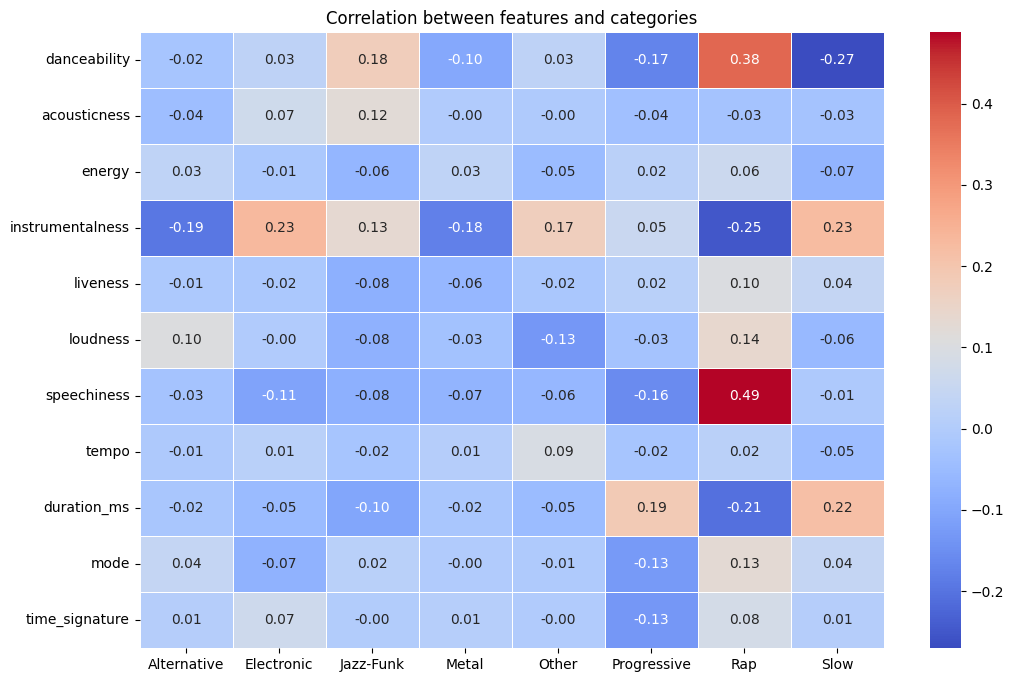

In [14]:
corr_data = data[features + featuresC + [category]]
categories = list(corr_data[category].value_counts().keys())

corr_data = pd.get_dummies(corr_data, columns=[category], prefix='', prefix_sep='')

corr_matrix = corr_data.corr()
corr_matrix.drop(features+featuresC, axis=1, inplace=True)
corr_matrix.drop(categories, axis=0, inplace=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation between features and categories')
plt.show()

Both the code and the graph is I hope pretty self-explanatory. Only part that maybe isn't as obvious is that to make the map we need to turn the single category column into multiple binary columns, which we do by the pd.get_dummies

### Genres visualisation using t-SNE

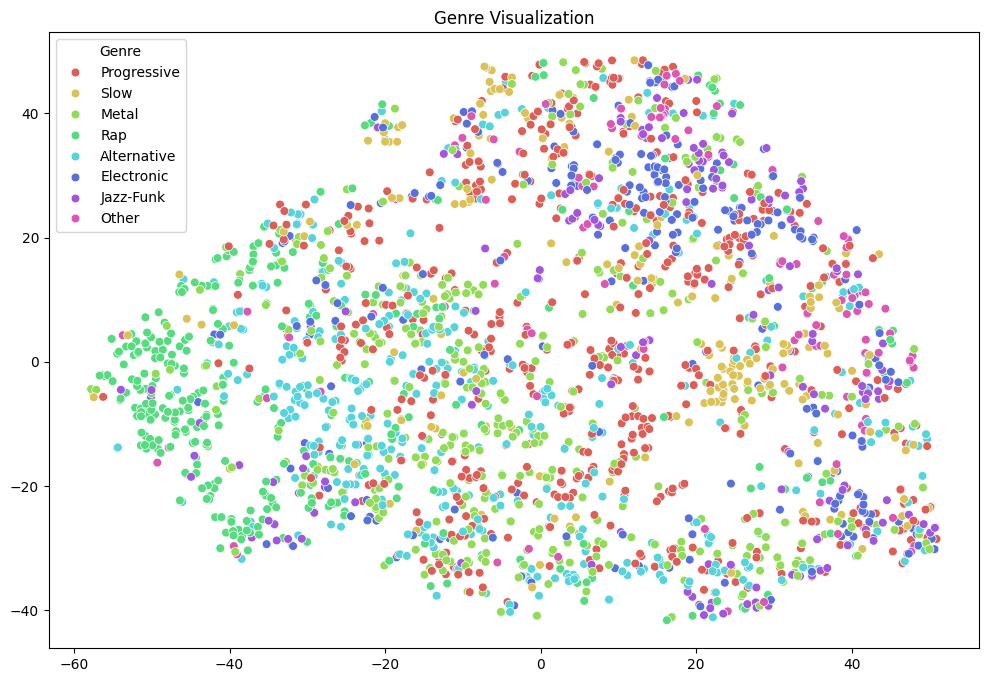

In [15]:
Y_projeciton = data[atr.CATEGORY].values
categories = list(set(Y_projeciton))

X_projection = TSNE(n_components=2).fit_transform(X)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=X_projection[:, 0], y=X_projection[:, 1], hue=Y_projeciton, palette=sns.color_palette("hls", len(categories)), s=40)
plt.title('Genre Visualization')
plt.legend(title='Genre')
plt.show()

This visualisation a little bit more messy, but that is to be expected as real world data isn't perfect, especially when it comes to a more loose topic of music genre classification. Also we need to remember that to fully understand the visualisation we would need to see in 11D.

The good thing is that we still can see some clear groupings and other more scrambled groupings.

What we get from the visualisation is that of course the Other genres are all over the place, but even more so, Progressive genres are even more varied, which I was predicting before while dealing with clusterization.

In conclusion we need to delete these two families, because they're far too unpredictable in this dataset and will just confuse our model with unnecessary noise 

In [16]:
data = data[data[atr.CATEGORY] != "Other"]
data = data[data[atr.CATEGORY] != "Progressive"]
categories = [cat for cat in categories if cat != "Other" and cat != "Progressive"]

## Classification model
For this classification problem we will be using the SVC algorithm.

### Sampling data
We need to sample the data so there is the same number of every category or else the model will tend to predict the largest categories more

162


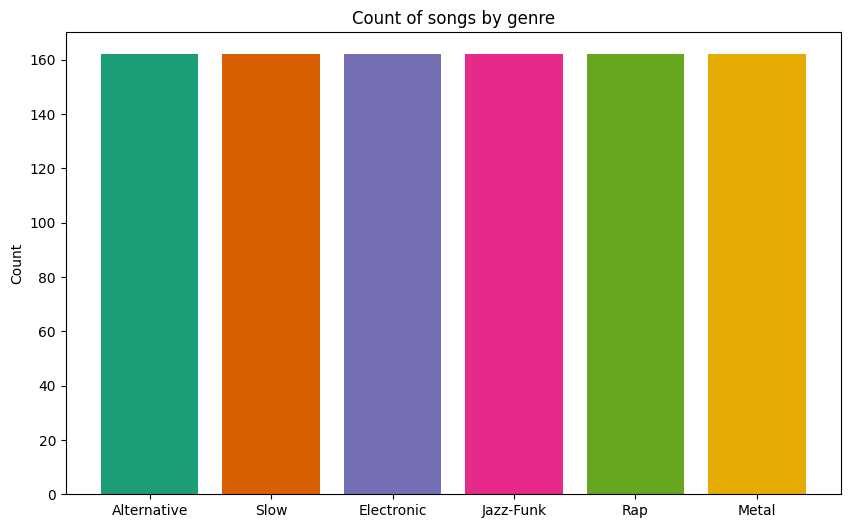

In [17]:
sample_size = data[atr.CATEGORY].value_counts().min()
print(sample_size)
sampled_data = pd.DataFrame()

for genre in categories:
    sampled_data = pd.concat([sampled_data, data[data[atr.CATEGORY] == genre].sample(n=sample_size, random_state=42)]) 

genre_valuecounts = sampled_data[atr.CATEGORY].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(genre_valuecounts.keys(), genre_valuecounts.values, color=plt.get_cmap('Dark2').colors)
plt.title("Count of songs by genre")
plt.ylabel('Count')
plt.show()


### Preparing the data for training

In [18]:
X = sampled_data.drop(columns=[atr.GENRE, atr.CATEGORY])
X[features] = sc.fit_transform(X[features])

Y = sampled_data[atr.CATEGORY].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

### Searching for the best SVC parameters by GridSearch

In [19]:
grid_parameters = {
    'C': [0.1, 1, 4, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.005, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), grid_parameters, verbose=2)
grid.fit(X_train, Y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=0.0

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 4, 10, 100],
                         'gamma': [1, 0.1, 0.01, 0.005, 0.001],
                         'kernel': ['rbf']},
             verbose=2)

## Results

/tmp/ipykernel_10947/2721182878.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=metrics_scores, y=metrics_names, orient='h', palette=plt.get_cmap('Dark2').colors)


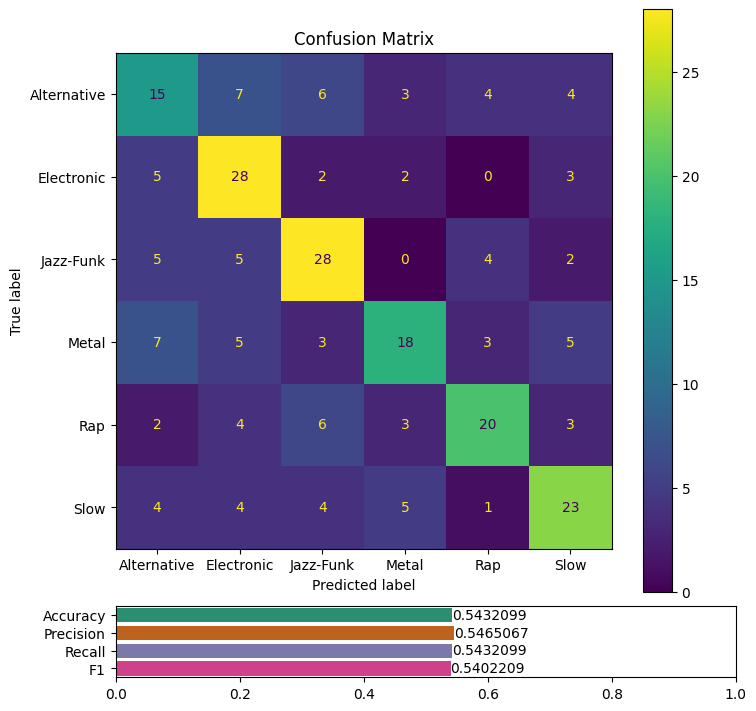

In [20]:
Y_pred = grid.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred, average="weighted")
recall = recall_score(Y_test, Y_pred, average="weighted")
f1 = f1_score(Y_test, Y_pred, average="weighted")


fig = plt.figure(figsize=(8, 12))
gs = gridspec.GridSpec(11, 1, figure=fig)

# Confusion Matrix
ax0 = plt.subplot(gs[:7])
display = ConfusionMatrixDisplay(cm, display_labels=pd.Categorical(categories).categories)
display.plot(ax=plt.gca())
plt.title('Confusion Matrix')

# Metrics
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1']
metrics_scores = [accuracy, precision, recall, f1]

ax1 = plt.subplot(gs[7:8:-1]) 
sns.barplot(x=metrics_scores, y=metrics_names, orient='h', palette=plt.get_cmap('Dark2').colors)
plt.xlim(0, 1)
for i, score in enumerate(metrics_scores):
    plt.text(score, i, round(score, 7), va='center')

plt.show()

## Summary
The model is definitely at least somewhat accurate, although there is also a lot of noise, so we can deduce that the data isn't particulary clear.

I don't think the model could improve in any meaningful way by using different methodologies. The problem here is the classification. 

The reason why the model isn't as good is that the genre of an album or artist is too general to properly categorize a song. Albums often contain different sounding songs, that sometimes could be classified as whole other genres. There are also variety albums where each song is different or even just an album that switches between calm and upbeat sounds.  
If the genres were scraped from the artist instead of the album, then the problem is even bigger, as many artists vastly change their sound over the course of their careers.

It would be wiser to make an album genre predicting model, by for example using the average features from it or maybe even using regression to get them, although that might be overkill

But let's not forget that current features might not be enough. Sometimes a simple change of instruments or the song structure can lead to a different song genre.

*****
All in all, despite the imperfections of the final result I rate this experience as a success. I've learned many interesting concepts while having a great time (maybe not as much so while scraping the data :D).